# spaCy klasifikátor jako transferové učení BERT modelu 

Trénink integrovaného klasifikátoru spaCy `Language.update()` pomocí transferového učení z Google BERT modelu. Notebook je až na použití transformerů stejný jako předchozí notebook s konvoluční sítí. Liší se až od části *Načtení modelu*. Oproti předchozímu modelu importuje PyTorch, který umožňuje nastavení tréninku na GPU. Použití transformerů čerpá z článku [spaCy meets Transformers](https://explosion.ai/blog/spacy-transformers).

#### Obsah notebooku

1. Vytvoření složky pro model
1. Načtení datasetu do datového rámce pomocí *pandas*
1. Příprava dat
1. Analýza datasetu pomocí knihovny *seaborn*
1. Vyvážení dat
1. Rozdělení na trénovací a testovací data
1. Formátování dat pro klasifikační úlohu
1. Vytvoření klasifikátoru
1. Příprava várek pro trénink
1. Trénink klasifikátoru
1. Evaluace klasifikátoru
1. Byznys analýza dat pomocí vizualizace a kontingenčních tabulek

## Vytvoření složky pro model

In [1]:
from pathlib import Path
# Výstupní složka pro obohacený model
output_dir = Path("BERT_model_categorizer")
if not output_dir.exists():
    output_dir.mkdir()

## Načtení datasetu
Data budeme načítat do datového rámce `pandas`. Proto nejdříve importujeme knihovnu a označíme aliasem `pd` pro snazší použití.

In [2]:
import pandas as pd

Načtení dat do datového rámce provedeme funkcí `read_csv`. 

Použité parametry:
- `"hotel_data.csv"` na první pozici je jméno k souboru s daty. Cesta není v názvu obsažena, protože je na stejném umístění jako notebook.
- `index_col=False` značí, že datový soubor nemá sloupec s indexem řádků. Přidá se tak inkrementální index od 0.
- `usecols=['stars', 'text']`, použijí se jen sloupce se škálovým hodnocením `stars` a text hodnocení `text`. Protože pracujeme se jmény, nezáleží na pořadí, ale na přesných názvech sloupců.
- `dtype={'stars':"string", 'text':"string"})` nastaví datové typy sloupců (objekt `Series`). Protože se jedná o pojmenované pole, nezáleží na pořadí, ale na přesných názvech sloupců. Možné datové typy jsou popsny v sekci [dtypes](https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#basics-dtypes) oficiálního průvodce.

Pokud by soubor obsahoval speciální oddělovače, kódování, nebo způsob quotování dat, použili bychom i další parametry dle sekce [CSV & text files](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#io-read-csv-table) průvodce. Zpracování dalších typů dat je přehledně popsané v sekci [IO tools](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html).

Jméno proměnné `df` na konci bloku kódu způsobí, že pod blokem se rámec vykreslí.

In [3]:
df = pd.read_csv("hotel_data.csv", 
                 index_col=False, 
                 usecols=['stars', 'text'], 
                 dtype={'stars':"string", 'text':"string"})
df

stars                                               text
0     5 of 5 stars  We were together with some friends at the Anew...
1     4 of 5 stars  Martin and his staff are truely great! They ma...
2     5 of 5 stars  We have stayed at the Excelsior on numerous oc...
3     5 of 5 stars  The great reviews are well deserved. Stayed he...
4     5 of 5 stars  Not sure we can add anything to the accurate r...
...            ...                                                ...
7149  5 of 5 stars  An incredible ride for 10 euros return. Wonder...
7150  5 of 5 stars  Bolzano proper--the old city--takes about a da...
7151  5 of 5 stars  This was the cheapest gondola we had ever ridd...
7152  5 of 5 stars  This cable ride up into the hills is a visual ...
7153  5 of 5 stars  We spent 4 days in Bolzano and were a little c...

[7154 rows x 2 columns]

## Příprava dat

Podobně jako jiné modely, využijeme pro trénování sentimentu recenzí škálové hodnocení. To bude potřeba:
1. převést z textu na číselné hodnoty,
1. převést na širší kategorie,
1. odstranit neutrální hodnocení.

### Převedení hodnocení na číslo
Pro převedení hodnocení ve stylu `5 of 5 stars` z řetězce na číslo stačí načíst první znak a ten převést na číslo.

`pandas` umožňuje operovat s řetězci nad celým sloupcem. Taková úprava je daleko rychlejší, než kdyby se iterovalo přes každý řádek. K úpravám se používají [funkce začínající `str.`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.html?highlight=str) (technicky se nejedná o objekt, ale kategorii metod). Funkce je možné volat nad objektem `Series`, která obsahuje datový typ string.

K zachycení prvního znaku použijeme metodu `str.slice` s parametrem `stop` a hodnotou `1`. Tím se zajistí, že načítání se zastaví po prvním znaku.

Následuje přetypování série (sloupce) na číselný datový typ a uložení zpět do datového rámce.

In [4]:
stars = df["stars"].str.slice(stop=1)
stars = stars.astype(int)
df["stars"] = stars
df

stars                                               text
0         5  We were together with some friends at the Anew...
1         4  Martin and his staff are truely great! They ma...
2         5  We have stayed at the Excelsior on numerous oc...
3         5  The great reviews are well deserved. Stayed he...
4         5  Not sure we can add anything to the accurate r...
...     ...                                                ...
7149      5  An incredible ride for 10 euros return. Wonder...
7150      5  Bolzano proper--the old city--takes about a da...
7151      5  This was the cheapest gondola we had ever ridd...
7152      5  This cable ride up into the hills is a visual ...
7153      5  We spent 4 days in Bolzano and were a little c...

[7154 rows x 2 columns]

## Analýza dat
Jakmile je hodnocení číselné, lze zobrazit na grafu. Pro zobrazení je nejsnazší použít knihovnu [seaborn](https://seaborn.pydata.org/), která jako vstup akceptuje datové rámce a, jak ukazuje [galerie příkladů](https://seaborn.pydata.org/examples/index.html) nebo [dokumentace](https://seaborn.pydata.org/api.html), nabízí knihovna velké možnosti zobrazení.

In [5]:
import seaborn as sns

Ačkoli jsme převedli hodnocení na čísla, prakticky se jedná spíše o ordinální data. Proto je zobrazíme jako počty výskytů v kategorii pomocí metody [`countplot`](https://seaborn.pydata.org/generated/seaborn.countplot.html#seaborn.countplot).

Parametry:
- `x="stars"` vybírá sloupec rámce s kategoriemi pro osu x. Pokud bychom namísto x uvedli osu y, graf by se přeorientoval.
- `data=df` vybírá datový rámec, který máme uložený v proměnné `df`
- `palette` barevná paleta, viz [matlab colormaps]( https://matplotlib.org/tutorials/colors/colormaps.html).

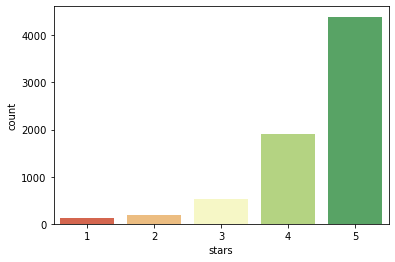

In [6]:
sns.countplot(x="stars", data=df, palette="RdYlGn")

## Převedení na širší kategorie

Učení jemnějších kategorií je náročnější, proto krajní hodnoty na každé straně sdružíme do košů a vytvoříme tři kategorie `NEGATIVE` (od 0 od 2), `NEUTRAL` (jen 3) a `POSITIVE` (od 4 do 5). K tomu nám poslouží pandas metoda [`cut`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html).
Jelikož pracujeme s číselnými hodnotami, je podstatné, jestli jsou intervaly otevřené, nebo uzavřené, a na kterých koncích. Podrobnosti jsou v [dokumentaci metody cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html).

Výsledek uložíme do nového sloupce s názvem `sentiment`. Voláním stejné metody `countplot` na novém sloupci zobrazíme nové rozložení.

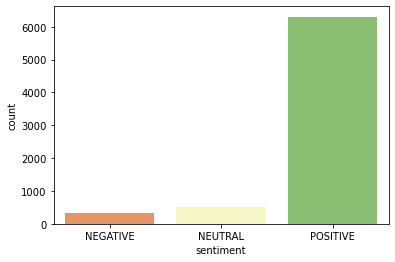

In [7]:
df["sentiment"] = pd.cut(df["stars"], 
                   bins=[0,2.9,3,5], 
                   labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
sns.countplot(x="sentiment", data=df, palette="RdYlGn")

Metoda `cut` vytvořila sloupec `sentiment` jako kategoriální datový tip. V něm jsou pevně dané kategorie, které zefektivňují zpracování dat.

Nově vzniklé kategorie můžeme prozkoumat voláním funkce `dtype` na sloupci datového rámce.

In [8]:
df.sentiment.dtype

CategoricalDtype(categories=['NEGATIVE', 'NEUTRAL', 'POSITIVE'], ordered=True)

Pro přesné počty v kategoriích můžeme na datovém rámci zavolat metodu `groupby`. Parametrem je název sloupce `sentiment` ke kterému vytváříme skupiny.

In [9]:
df.groupby("sentiment").count()

stars  text
sentiment             
NEGATIVE     324   324
NEUTRAL      526   526
POSITIVE    6304  6304

## Odstranění neutrální kategorie

Prostřední kategorie `NEUTRAL` je pro učení problematická, protože obsahuje velmi nevyvážená textová hodnocení. Datový rámec můžeme na neutrální hodnocení omezit podmínkou uvedenou v hranatých závorkách, kde je uveden odkaz na slupec rámce `df.sentiment`, operátor rovnosti `==` a hodnota `NEUTRAL`, která nás zajímá.

In [10]:
df[df.sentiment == "NEUTRAL"]

stars                                               text sentiment
32        3  Nice suite! Spa was good except for the arroga...   NEUTRAL
111       3  The room was very small, the shower was terrib...   NEUTRAL
143       3  What you are served with is good food no doubt...   NEUTRAL
166       3  This place has a very unusual and traditional ...   NEUTRAL
203       3  Typically baroque and quite interesting. Worth...   NEUTRAL
...     ...                                                ...       ...
7138      3  Is in the center of everything. I have never h...   NEUTRAL
7139      3  You'd go for a beer and a pretzel, but dinner ...   NEUTRAL
7141      3  The beer is nice but the service is just so so...   NEUTRAL
7142      3  Good beer, nice pub-style food, bustling atmos...   NEUTRAL
7143      3  The beer is absolutely tops. Service was lukew...   NEUTRAL

[526 rows x 3 columns]

K odstranění všech řádků s neutrální kategorií použijeme pandas metodu [`drop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html).

Funkce drop potřebuje jako vstup indexy řádků k odstranění. Ty snadno zjistíme voláním podmínky nad datovým rámcem a vlastosti `index`, kde je uložený seznam indexů.

In [11]:
indicies_to_drop = df[df.sentiment == "NEUTRAL"].index

indicies_to_drop

Int64Index([  32,  111,  143,  166,  203,  226,  232,  333,  373,  384,
            ...
            7109, 7115, 7116, 7120, 7121, 7138, 7139, 7141, 7142, 7143],
           dtype='int64', length=526)

Funkce `drop` pouze vrací kopii upraveného rámce, proto je potřeba jej zpět uložit do proměnné `df`.

Pro kontrolu pak vypíšeme počty kategorií opět metodou `groupby`.

In [12]:
df = df.drop(indicies_to_drop)

df.groupby("sentiment").count()

stars  text
sentiment             
NEGATIVE     324   324
NEUTRAL        0     0
POSITIVE    6304  6304

Jelikož kategorie zůstavá i bez výskytů, odebereme jí voláním `remove_unused_categories` nad vlastností `cat`, která umožňuje spravat kategorie sloupce.

Pro kontrolu zobrazíme graf a vypíšeme podobu kategorií.

CategoricalDtype(categories=['NEGATIVE', 'POSITIVE'], ordered=True)

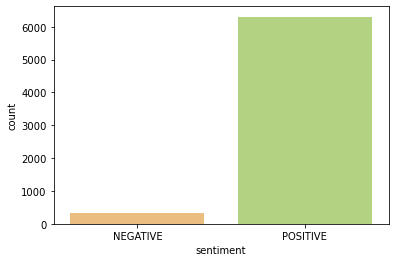

In [13]:
df.sentiment = df.sentiment.cat.remove_unused_categories()
sns.countplot(x="sentiment", data=df, palette="RdYlGn")
df.sentiment.dtype

## Vyvážení dat

Výrazně nevyvážené zastoupení kategorií by mohlo ovlivnit učení klasifikace textu. 

Pro vyvážení lze použít (a) **váhy** při trénování, nebo (b) **oversampling** Viz [doporučení na tenserflow](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
 
Tím, že jsme omezeni funkcionalitou spaCy pro možnosti tréninku (na úkor jenoduchosti), vybalancujeme model snížením četnosti pozitivních příspěvků (oversampling).

**Metoda**:
Vyvážení docílíme tím, že si připravíme dva řezy datovým rámcem, jeden s pozitivními komentáři a jeden s negativními. Z toho v četné kategorii vybereme náhodně vzorek dat, který se bude blížit počtu v druhé kategorii. Protože nemáme tolik dat, nemusí to být přesně 1:1 a četnější kategorie může drobně převládat. Rozdělené části pak spojíme zpět zřetězením.

Řezy si uložíme do proměnných `df_neg` a `df_pos`.

In [14]:
df_neg = df[df.sentiment=="NEGATIVE"]
df_pos = df[df.sentiment=="POSITIVE"]

Z četné kategorie vybereme náhodný vzorek pěti set řádků pandas funkcí [`sample`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html?highlight=sample#pandas.DataFrame.sample). Jako jediný parametr použijeme počet řádků (totéž jako pojmenovaný parametr `n`). Alternativně by šlo použít i proporcionální rozdělení, které nabízí parametr `frac`.

In [15]:
df_pos = df_pos.sample(500)

Jednotlivé části opět zřetězíme pandas funkcí [`concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html?highlight=concat#pandas.concat).

Parametry:
- `[df_neg, df_pos]` značí pole datových rámců pro zřetězení. Předpokládá se, že mají stejné sloupce. Pokud by němly vyplní se prázdné hodnoty.
- `ignore_index=True` ignoruje předešlý index a vytovoří nový.

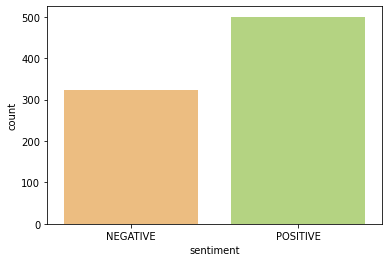

In [16]:
df = pd.concat([df_neg, df_pos], ignore_index=True)
sns.countplot(x="sentiment", data=df, palette="RdYlGn")

## Příprava formátu kategorií pro trénink

spaCy pro trénink očekává pojmenované pole s názvy kategorií jako klíči a logickými hodnotami kategorií. Pole uložíme nového sloupce `cats`.

Nejlepší způsob, jak uložit pojmenovaná pole do řádků datového rámce je připravit si je jako do pole velikosti počtu řádků datového rámce. To se snadno vytvoří iterací nad hodnotami sloupce `sentiment` v cyklu. Při každém průchodu se porovnají hodnoty sentimentu s hodnotami v pojmenovaném poly a zapíší do pole.

In [17]:
df["cats"] = [{"POSITIVE": y=="POSITIVE", "NEGATIVE": y=="NEGATIVE"} for y in df.sentiment]

## Rozělení na trénovací a testovací data

Před rozdělením je nezbytné promíchat data. K tomu nám pomůže opět funkce `sample`, na které budeme volat propocionální parametr `frac` s hodnotou `1`, která vrátí stejnou množinu dat, ale jinak uspořádanou.

In [18]:
df = df.sample(frac=1) #shuffle, případně i procentuální subset
df

stars                                               text sentiment  \
189      2  The hotel has many facilities (indoor and outd...  NEGATIVE   
657      4  Delicious food, generous portions and very goo...  POSITIVE   
164      1  There is a night club immediately opposite whi...  NEGATIVE   
393      4  When booking the Laurin through an online book...  POSITIVE   
814      4  We were three friends arriving in Bolzano and ...  POSITIVE   
..     ...                                                ...       ...   
579      5  For those who are planning a vacation on Dolom...  POSITIVE   
331      5  We had a lovely lunch at Armentarola while sta...  POSITIVE   
603      5  We chose Hotel Digon after reading the great r...  POSITIVE   
540      4  We enjoyed Voegele ate there twice. We have be...  POSITIVE   
426      5  We spent some hours with the family at that pl...  POSITIVE   

                                      cats  
189  {'POSITIVE': False, 'NEGATIVE': True}  
657  {'POSITIVE': True, 'NEGATIVE': False}  
164  {'POSITIVE': False, 'NEGATIVE': True}  
393  {'POSITIVE': True, 'NEGATIVE': False}  
814  {'POSITIVE': True, 'NEGATIVE': False}  
..                                     ...  
579  {'POSITIVE': True, 'NEGATIVE': False}  
331  {'POSITIVE': True, 'NEGATIVE': False}  
603  {'POSITIVE': True, 'NEGATIVE': False}  
540  {'POSITIVE': True, 'NEGATIVE': False}  
426  {'POSITIVE': True, 'NEGATIVE': False}  

[824 rows x 4 columns]

Proporci rozdělení určíme jako 80% trénovacích a 20% testovacích dat. Pro rozdělení budeme potřebovat najít index předělového řádků.

In [19]:
split = 0.8
split_row = int(len(df) * split)
split_row

659

Se známým indexem předělového řádku zavoláme výběr z datového rámce pomocí výrazu s hranatými závorkami a dvojtečkou. Pozice dvojtečky oproti proměnné s indexem naznačuje, která část řádků se uloží. První menší část se uloží jako testovací, druhá větší jako trénovací. 

Pro kontrolu si zobrazíme délku množin.

In [20]:
df_test = df[split_row:]

len(df_test)

165

In [21]:
df_train = df[:split_row]

len(df_train)

659

## Formátování dat pro spaCy `update` a `evaluate` funkci
spaCy [`update`](https://spacy.io/api/textcategorizer#update) funkce objektu [`TextCategorizer`](https://spacy.io/api/textcategorizer) očekává kolekci dvojic s textem a anotacemi kategorií.

In [22]:
train_data = list(zip(df_train["text"], [{"cats": cats} for cats in df_train["cats"]]))
test_data = list(zip(df_test["text"], [{"cats": cats} for cats in df_test["cats"]]))

train_data[:3]

[('The hotel has many facilities (indoor and outdoor pool, sauna, turkish bath, tennis courts...), but none of them is particularly good. The ""spa"" is very basic, with no relax area (just a few plastic beach chairs) and no atmosphere at all. The swimming pool would be nice, with very warm water, but it was small and packed with noisy children all the time. The rooms in the dependance are super-small (and I mean REALLY small!) and VERY old, carpets are torn and dirty, and the corridor and stairs smell of smoke (I suspect it\'s hotel employees leaving downstairs and smoking in their rooms...). And: it\'s true that the dependance is just 10 meters from the main hotel building, but you have to cross a (relatively) busy street in your bathrobe and slippers to get to the sauna (no changing room there: big problem if it\'s cold or rainy!)... And no zebra crossing nor lighting at night, so you have to be very careful! Food was average (good antipasti buffet on Saturday though!), water too ex

## Načtení jazykového modelu
Model s transformery je třeba předem stáhnout (není na školním image). Více oficiálních informací o dostupných modelech a práci s nimi přinese novější verze spaCy (pravděpodobně až verze 3). Seznam dostupných modelů najdete na gitu [spacy-models](https://github.com/explosion/spacy-models/releases).

Instalaci modelu, včetně závislostí, provedete příkazem `python -m spacy download en_trf_bertbaseuncased_lg`. Více informací k práci s transformery ve spacy poskytuje balíček [spacy-transformers](https://pypi.org/project/spacy-transformers/).

In [ ]:
!python -m spacy download en_trf_bertbaseuncased_lg

In [24]:
import spacy
nlp_trf = spacy.load("en_trf_bertbaseuncased_lg")

Načtený model má od klasických spaCy modelů odlišnou pipeline.
![trf pipeline](https://explosion.ai/b6c9c5d33ce4ae6727cde0ac60132cdb/spacy-trf_pipeline.svg)

Model pracuje namísto tokenů s jemnějšími částmi slov **word pieces**. Práce s částmi slov zpřesňuje interpretaci významu slov protože odlišuje všechy předpony a přípony slova, jako např. gerundia *-ing* nebo významové prefixy jako *a-* nebo *dis-*. Tento přístup pomáhá významně s velikostí slovníku a přítomností slov ve slovníku (OOV).

Kromě klasických atributů spaCy objektu `Doc` lze použít i atribut `tensor`.

In [25]:
doc = nlp_trf("Here is some text to encode.")

In [26]:
doc._.trf_word_pieces_

['[CLS]', 'here', 'is', 'some', 'text', 'to', 'en', '##code', '.', '[SEP]']

>The most important features are the raw outputs of the transformer, which can be accessed at `doc._.trf_outputs.last_hidden_state`. This variable gives you a tensor with one row per wordpiece token. 

In [27]:
doc._.trf_last_hidden_state

array([[-0.09978373, -0.07679981, -0.15845335, ..., -0.4191932 ,
         0.09268837,  0.78295   ],
       [-0.5742767 , -0.47929192, -0.1595142 , ..., -0.78060275,
         0.13546294, -0.21286227],
       [-0.19338603, -0.6990963 ,  0.03319715, ..., -0.20400535,
        -0.3018549 ,  0.7169385 ],
       ...,
       [ 0.544879  ,  0.46257883,  0.08483294, ..., -0.4931733 ,
        -0.20977676, -0.1396877 ],
       [ 0.40077415,  0.21478848, -0.50173783, ...,  0.2455071 ,
        -0.27700347, -0.5046498 ],
       [ 0.71843547,  0.41700333, -0.3470154 , ...,  0.23971565,
        -0.63383335, -0.2944397 ]], dtype=float32)

> The `doc.tensor` attribute gives you one row per spaCy token, which is useful if you’re working on token-level tasks such as part-of-speech tagging or spelling correction.

In [28]:
doc.tensor

array([[-0.48589784, -0.43069142, -0.23172402, ..., -0.8062424 ,
         0.05815652, -0.14307508],
       [-0.10500722, -0.6504958 , -0.03901267, ..., -0.229645  ,
        -0.37916133,  0.7867257 ],
       [ 0.07593238, -0.45352623,  0.24927679, ...,  0.28133366,
        -0.45936918,  0.8306135 ],
       ...,
       [ 0.85404617,  0.04648557,  0.01456683, ...,  0.26930547,
         0.07758008,  0.57686734],
       [ 0.8994542 ,  0.66806483,  0.29163358, ..., -0.68938386,
        -0.82939464,  0.54646796],
       [ 0.48915297,  0.263389  , -0.57394767, ...,  0.21986745,
        -0.3543099 , -0.43486264]], dtype=float32)

In [29]:
apple1 = nlp_trf("Apple shares rose on the news.")
apple2 = nlp_trf("Apple sold fewer iPhones this quarter.")
apple3 = nlp_trf("Apple pie is delicious.")
print(apple1[0].similarity(apple2[0]))
print(apple1[0].similarity(apple3[0]))

0.7342853
0.4336571


## Nastavení výpočtu na grafické kartě
V případě, že zkoušíte notebook doma, je rozumné použít grafickou kartu.
Nastavení je možné změnit po importu [`torch`](https://pytorch.org/) knihovny.

In [30]:
import torch
is_using_gpu = spacy.prefer_gpu()
if is_using_gpu:
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

## Vytvoření klasifikátoru

Vytvoříme novou pipeline komponentu pomocí [`nlp.create_pipe`](https://spacy.io/api/language#create_pipe).

Parametry:
- Na první pozici je parametr ID. Instance třídy TextCategorizer s transfomery má ID `trf_textcat`.
- Konfigurace:
  - `exclusive_classes`, logická hodnota, zda jsou kategorie/třídy výlučné. Pozitivní a negativní sentiment je výlučný, proto použijeme `True`.
  - `architecture`, architekturu modelu neuvádíme

In [31]:
textcat = nlp_trf.create_pipe("trf_textcat", config={"exclusive_classes": True})

Přidáme do pipeline [`nlp.add_pipe`](https://spacy.io/api/language#add_pipe). Parametr `last` určuje pozici, kam se má klasifikátor přidat.

In [32]:
nlp_trf.add_pipe(textcat, last=True)

Do nově vytvořeného klasifikátoru přidáme kategorie `POSITIVE` a `NEGATIVE`.

In [33]:
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

textcat.labels # výpis pro ověření

('POSITIVE', 'NEGATIVE')

## Příprava velikosti várek (batches) pro trénink

Aby se model mohl postupně učit. Je třeba rozmyslet charakter procházení sady příkladů v tréninkové množině. V úvahu je třeba vzít, kdy model aktualizuje své parametry.

V zásadě existují tři způsoby aktualizace:
- Parametry se aktualizují po shlédnutí všech příkladů (batch). Způsob je přesnější ale náročnější na zdroje.
- Parametry se aktualizují po shlédnutí každého příkladu jednotlivě (stochastic). Méně přesné, ale méně náročné na zdroje. Může dojít k oscilaci při hledání minima.
- Něco mezi tím (minibatch), lze libovolně nastavit a proto volíme i v tomto případě.

Pro přípravu várek má spaCy dvě funkce:
- [`compouding`](https://spacy.io/api/top-level#util.compounding ) pro přípravu počtu příkladů ve várce,
- [`minibatch`](https://spacy.io/api/top-level#util.minibatch) pro přípravu sady příkladů.

Počet várek je ideální postupně zvyšovat (viz [tipy v dokumentaci](https://spacy.io/usage/training#tips-batch-size)). U klasifikátoru, je možné začít na vyšších počtech. 

In [34]:
from spacy.util import minibatch, compounding

Po opakovaném volání by `batch_sizes` vracela největší várku, proto musíme iterátor pokaždé znovu připravit.

Kromě `compunding` se hodí metoda `minibatch`, která podle velikostí várek rovnou připraví odpovídající části pole. 

## Trénink

### Cykly tréninku
Trénink probíhá ve dvou do sebe vnořených cyklech:
1. iterace nad celou tréninkovou množinou (epocha) `for i in range(n_iter)`
1. iterace nad připravenými várkami příkladů `for batch in batches`

Počet iterací nad datasetem (epoch) nastavíme parametrem `n_iter`.

In [35]:
n_iter = 20

### Zamíchání příkladů

Při každé iteraci nad celou tréninkovou množinou se vzorek příkladů zamíchá `random.shuffle()`. Metodu je třeba importovat z knihovny `random`.

### Dropout rate
spaCy umožňuje pro trénink nastavit **dropout rate**.

>Another technique to improve the learning results is to set a dropout rate, a rate at which to randomly “drop” individual features and representations. This makes it harder for the model to memorize the training data. For example, a 0.25 dropout means that each feature or internal representation has a 1/4 likelihood of being dropped.

In [36]:
dropout = 0.8

### Konstrukce `with`
V bloku pro trénink použijeme python konstrukci `with`, pomocí které
- můžeme pracovat s **dočasně** odebranýmy pipes modelu. `with nlp.disable_pipes(other_pipes)`
- Později ho použijeme i během iterací pro **dočasnou** aplikaci aktualizovaného modelu při evaluaci iterace. `with textcat.model.use_params(optimizer.averages)`

### Evaluace modelu
Evaluace modelu probíhá po každé iteraci na druhé části dat (`test_data`), které jsme si dali před tréninkem na stranu a připravili je do stejného formátu jako tréninková data. 

Při evaluaci není možné využít vestavěný Scorer a sledujeme balíčku spaCy tak sledujeme konečný výsledek ztrátové funkce, který se ukládá při každém volání `nlp.update` do proměnné `losses`.

Vyzkoušíme proto evaluaci modelu z balíčku `sklearn`. Ten nabízí např. ROC (Receiver Operating Characteristic) křivku s AUC metrikou.
>ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

>The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

In [37]:
from sklearn import metrics
import numpy as np

ROC křivka se získá funkcí [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html), kde první parametr `y` představuje testovací data, druhý parametr predikovaná data. `pos_label` umožňuje nastavit hodnotu, která ve skóre odpovídá `1`.

Jak by vypadala ROC křivka při náhodných odhadech?

In [38]:
y = df_test["sentiment"] # ["POSITIVE", "NEGATIVE", "POSITIVE", "NEGATIVE", ...]
random_scores = np.random.rand(len(df_test.sentiment)) # náhodné skóre od 0 (NEGATIVE) do 1 (POSITIVE)

fpr, tpr, thresholds = metrics.roc_curve(y, random_scores, pos_label="POSITIVE") # kalkulace ROC

AUC skóre vypočteme z výsledků `roc_curve` funkcí [`auc`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

In [39]:
metrics.auc(fpr, tpr)

0.43280696100547855

Zobrazení na grafu pomocí `seaborn` knihovny a funkce `lineplot`

[Text(0, 0.5, 'True Positive'), Text(0.5, 0, 'False Positive')]

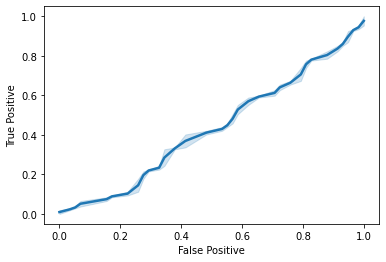

In [40]:
plot = sns.lineplot(x=fpr, y=tpr, linewidth=2.5)
plot.set(xlabel='False Positive', ylabel='True Positive')

In [41]:
import random # pro zamíchání příklady v iteraci
import matplotlib.pyplot as plt # pro zobrazování grafu v iteracích

In [ ]:
score = pd.DataFrame() # dataframe pro výsledky
print("trénink.", end="") # začátek tisku průběhu na řádek
    
optimizer = nlp_trf.resume_training() # získání optimalizátoru    

for i in range(n_iter): # iterace přes celou tréninkovou množinu (epocha)
    print(i, end="") # tisk průběhu další iterace na řádek
    losses = {} # příprava pro ukládání informací o ztrátách        
    random.shuffle(train_data) # zamíchání tréninkovou množinou
    batch_sizes = compounding(8.0, 20.0, 1.2) # várky musíme držet níž kvůli paměti
    batches = minibatch(train_data, size=batch_sizes) # načtení příkladů ve várkách    

    for batch in batches: # učení se na každé várce
        print(".", end="") # tisk průběhu další iterace na řádek
        texts, annotations = zip(*batch) # uložení polí dvojic do dvou separátních polí

        nlp_trf.update(texts, annotations, sgd=optimizer, drop=dropout, losses=losses) # samotné učení
    
    with textcat.model.use_params(optimizer.averages): # s dočasnou aplikací aktualizovaného modelu
            docs_generator = nlp_trf.pipe(df_test["text"]) # dávkové zpracování testovacích dokumentů
            docs = list(docs_generator) # načtení testovacích dokumentů do listu
            scores = [doc.cats["POSITIVE"] for doc in docs] # načtení sentimentu do listu
            
            # kalkulace ROC
            fpr, tpr, thresholds = metrics.roc_curve(y_true = df_test["sentiment"], 
                                                     y_score = scores, 
                                                     pos_label = "POSITIVE")
            
            # zobrazení ROC grafu
            roc_plot = sns.lineplot(x=fpr, y=tpr, linewidth=2.5)
            roc_plot.set(xlabel='False Positive', ylabel='True Positive')
            plt.show() # zobrazení křivky za běhu buňky
            
            # vyplnění tabulky se skórem modelu v iteraci
            score.loc[i, "loss"] = losses["trf_textcat"] # zapsání končené ztráty do tabulky
            score.loc[i,"AUC"] = metrics.auc(fpr, tpr)
            
score #zobrazení tabulky se skóre po celém učení

Po uložení na disk, můžeme model opakovaně načítat a používat.

In [ ]:
with nlp_trf.use_params(optimizer.averages):
    nlp_trf.to_disk(output_dir)
print("Saved model to", output_dir)

## Vyzkoušení modelu na novém rámci
Natrénovaný model si vyzkoušíme na sadě textů. K tomu si připravíme nový datový rámec.

In [ ]:
examples = pd.DataFrame(["The rooms were clean.", "They went over and beyond to help make our stay enjoyable.",
                         "The breakfast is one of the best I have ever had in Europe.",
                         "I highly recommend this hotel for anyone visiting downtown", 
                         "We got to hotel super early", "The sevice was exceptional as well.",
                         "Every staff member I encountered were delightful and eager to help!",
                         "The bed was extremely comfortable.", "The room was spacious and clean.",
                         "Beautiful atmosphere inside and outside around that part of the city.",
                         "Everything what you need is possible.", "The room was huge, modern, and spotless.",
                         "This is a beautiful hotel!", "The environment was pleasant and welcoming.",
                         "We could park our motorcycles in the closed garage.", "Great value for money.",
                         "Must definitelly recommend breakfast, good food and variety of it.",
                         "Hot water constantly running out.", "Virtually no cooking utensils",
                         "Beds were extremely uncomfortable", "Pillows were solid hurting your neck when you slept.",
                         "My kid broke his arm there.", "Worst hotel I've stayed in.", "No Wi-Fi inside rooms.",
                         "Fridge was dirty and horrible and the bottom of it was rusty.", "Back-pain guaranteed.",
                         "Only way to let some fresh air inside is to open the main door.", 
                         "Limited hot water in apartments", "Barely slept all week.", 
                         "Staff are extremely rude and unhelpful", "Majority of hotel staff were miserable",
                         "Rooms smelt of cheap air freshener in an attempt to cover up a bad smell.",
                         "Furniture was cheap and didn't match (not a big deal)", "Smells very very ugly from bathroom.",
                         "standards were below what we were expecting."
                        ], 
                        columns=["text"])
examples

Pro operace s datovými rámci není efektivní iterovat, ale provádět vektorové operace např. pomocí flexibilního volání libovolné funkce pomocí [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html). 

Parametry [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html):
- jméno funkce, např. `np.sum` pro součet, 
- osu `axis` po které se apply provede
  - `0` se aplikuje po sloupcích
  - `1` se aplikuje po řádcích
- argumenty pro volanou funkci

Pro [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) si připravíme novou funkci `evaluate`. Jako parametr budeme očekávat řádek (sérii) `row` a jazykový model `nlp`, který vrací kategorie `POSITIVE` a `NEGATIVE`.

Do řádku přidáme nový sloupec `sentiment_score`, kam uložíme predikovanou hodnotu sentimentu. Stačí uložit pozitivní sentiment, protože kategorie jsou výlučné.

In [ ]:
def evaluate(row, nlp=nlp_trf):
    row["sentiment_score"]=nlp(row["text"]).cats["POSITIVE"]    
    return row

Pokud bychom chtěli sentiment jako kategorii, použijeme opět pandas funkci `pd.cut`, která nám z číselných hodnot vytvoří kategorie dle nastavených košů.

In [ ]:
examples = examples.apply(evaluate, nlp=nlp_trf, axis=1)

examples["sentiment"] = pd.cut(examples["sentiment_score"], 
                   bins=[0,0.4,0.6,1], 
                   labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
examples

### Vyzkoušení modelu z disku
Abychom vyzkoušeli i uložený model na disku, model načteme z adresáře metodou `spacy.load`.

In [ ]:
# test the saved model
nlp_disk = spacy.load(output_dir)

Zkopírujeme rámec s příklady a aplikujeme na něj naší funkci `evaluate`, ale tentokrát s novým jazykovým modelem.

In [ ]:
examples_disk = examples.copy()
examples_disk = examples_disk.apply(evaluate, nlp=nlp_disk, axis=1)
examples_disk["sentiment"] = pd.cut(examples_disk["sentiment_score"], 
                   bins=[0,0.4,0.6,1], 
                   labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
examples_disk

## Byznys analýza
V praxi nestačí jen klasifikovat text do kategorií, hlavní hodnota tkví v propojení s dalšími kategoriálními daty, které přidají kategoriím kontext. Přidáme sloupec s kategoriemi, které budou označovat hotel, ke kterému se komentář váže.

In [ ]:
import numpy as np
random_hotels = np.random.choice(["Modrá Hvězda", "Hotel Praha", "Hotel Moskva"], 
                                 size=len(examples.index))

examples.loc[:,"hotel"] = pd.Series(random_hotels, dtype="category")
examples

Zkontrolujeme, jak se vytvořily kategorie v datovém typu sloupce.

In [ ]:
examples.hotel.dtype

### Vizualizace
Vizualizovat datový rámec můžeme opět pomocí [seaborn](https://seaborn.pydata.org/) knihovny.

Protože potřebujeme zobrazit více dat, můžeme použít legendu, která se předá jako název sloupce pro parametr `hue`.

In [ ]:
sns.countplot(x="hotel", hue="sentiment", data=examples, palette="inferno")

### Kontingenční tabulka

Nad kategoriálními daty jdou efektivně provádět operace, jako například groupby nebo pivot. Viz [operace s kategoriálními daty](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html#operations) v dokumentaci pandas.

Funkce [`pivot_table`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot_table.html#pandas-dataframe-pivot-table) potřebuje jen několik parametrů:
- datový rámec na první pozici,
- `values` jako sloupec s hodnotami,
- `aggfunc` agregační funkci, která se aplikuje na hodnoty,
- `margins` součtové řádky
- `index` s polem sloupců, které budou tvořit index nové tabulky. Pole je to proto, že index může být hierarchický.

Pro přehlednost ještě seřadíme rámec podle sentimentu funkcí [`sort_values`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html).

In [ ]:
pd.pivot_table(examples, 
               values="sentiment_score", 
               aggfunc=["mean", "min", "max"], 
               index="hotel", 
               margins=True)

Případně s kategoriemi sentimentu jako dalším sloupcem indexu.

In [ ]:
pd.pivot_table(examples, 
               values=["sentiment_score", "sentiment"], 
               aggfunc={"sentiment_score":"mean", "sentiment":"count"}, 
               index=["hotel", "sentiment"],
               margins=True)

### Korelační matice
V pandas lze velmi snadno sestavit korelační matici pomocí funkce [`corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html).

Nejdříve si vytvoříme náhodný sloupec pro ilustraci. Použijeme opět `numpy.random` ale tentoktrát funkci `rand`. Funkce potřebuje jen počty čísle pro generování, co parametr to počet v jedné dimenzi.

In [ ]:
random_scores = np.random.rand(len(examples.index))

examples.loc[:,"rand_score"] = pd.Series(random_scores, dtype="float")
examples

Pak už jen zavoláme [`corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) na našem datovém rámci. Jako parametr lze vybrat konkrétní metodu.
>Method of correlation:
>- pearson : standard correlation coefficient
>- kendall : Kendall Tau correlation coefficient
>- spearman : Spearman rank correlation

In [ ]:
examples.corr()